# Prophet predictions:

In [2]:
import pandas as pd
import numpy as np
import prophet as pt
import datetime as dt
import os
import matplotlib.pyplot as plt
from prophet.plot import add_changepoints_to_plot


Importing plotly failed. Interactive plots will not work.


In [3]:
df = pd.read_csv('full_grid.csv')

In [4]:
df.reset_index()
df = df.groupby("grid_num")

In [5]:
def get_hour(datetime_o):
    """
    this function to get the hour of the day to use it as a custom seasonality as an active hours
    """
    return datetime_o.hour
def active_time(t):
    """
    function to determine if the hour is an active hour or not
    """
    if(t in range(4, 16)):
        return 1
    else:
        return 0

In [79]:
def init_prophet():
    """
    A  function to initialize the prophet model with best parameters
    and added some custome seasonalities
    """
    #inititating the model
    model = pt.Prophet(changepoint_range=0.9, changepoint_prior_scale=0.0005,
                       n_changepoints = 50, weekly_seasonality= 60,
                       daily_seasonality= 100,
                       holidays_prior_scale= 0.01,
                       seasonality_mode = "multiplicative")
    # Adding country holidays
    model.add_country_holidays(country_name= "IT")
    # add monthly seasonality
    model.add_seasonality(name='monthly', period=31, fourier_order=50)

    # Custom seasonality for times in day accoding to active time
    model.add_seasonality(name='daily_active_time', period=1,
                          fourier_order=50, condition_name='active_time')
    return model

In [7]:
def divide_data(iter_num, data, t_period , p_period ):
    """
    function to divide the data set into training and prediction sets
    """
    t_periods = {"week": 144*7, "month": 144*30}
    p_periods = {"day": 144, "week": 144*7}
    
    # For training set
    train_period = t_periods[t_period]
    start_t = p_periods[p_period]*iter_num
    end_t = start_t + train_period
    X_train = data.iloc[start_t:end_t, :]
    
    # For prediction set
    predict_period = p_periods[p_period]
    start_p = end_t
    end_p = start_p + predict_period
    X_predict = data.iloc[start_p:end_p, [0,2]]
    
    full_predict = data.iloc[start_p:end_p, 0:2]
    
    return [X_train, X_predict, full_predict]

In [8]:
def fit_predict(model, train, predict):
    """
    Function to train and predict form a model
    """
    # fitting the model
    model.fit(train)
    #making forecsting for the future 1-day
    forcast = model.predict(predict)
    return forcast

In [9]:
def prediction_dataframe(data, forcast_p, grid_num, iter_num):
    """
    this function is just to aggregate the predictions with the original
    data in the same dataframe to be able to store it and use it leter
    """
    # initiating the dataframe
    df_p = pd.DataFrame(columns = ["y","yhat","error", "ds", "grid"])
    #get the original data
    df_p["y"] = data["y"]
    ### resetting the index to allign the mesurments
    df_p.index = np.arange(df_p.shape[0])
    # get the frocased values
    df_p["yhat"] = forcast_p["yhat"]
    # error for predictions
    df_p["error"] = df_p["y"] - df_p["yhat"]
    #add the grid number 
    df_p["grid"] = grid_num
    #reseting the index again
    forcast_p["ds"].index = np.arange(df_p.shape[0])
    #adding the time to the dataframe
    df_p["ds"] = forcast_p["ds"]
    return(df_p)

In [10]:
def nrmse(df_p):
    """
    function to calculate the normalized root mea sqaure error
    """
    return np.sqrt((df_p["error"]**2).sum() / df_p.shape[0])/df_p["y"].mean()
def mape(df_p):
    """
    function to provide the mean absolute percentage error
    """
    return np.absolute(df_p["error"] / df_p["y"]).sum()/ df_p.shape[0]

# Forcasting


In [40]:
# Get the list of the grids in the city
grids = list(df.groups.keys())
# error dataframe initiation
arrays = [
    ["1 day","1 day", "7 days", "7 days" ] ,
    ["NRMSE", "MAPE", "NRMSE", "MAPE"],
]
# Error data frame columns index
errors = list(zip(*arrays))
#day_errors_dataframe
error_idex_d = pd.MultiIndex.from_tuples(errors[:2], names=["period", "metric"])
error_d = pd.DataFrame(columns = error_idex_d)
#week_errors_dataframe
error_idex_w = pd.MultiIndex.from_tuples(errors[2:], names=["period", "metric"])
error_w = pd.DataFrame(columns = error_idex_w)

# Making a day and a week predictions dataframes to store the values, predictions
# corresponding to each time steps
day_predictions = pd.DataFrame(columns = ["y","yhat","error", "ds", "grid" ])
week_predictions = pd.DataFrame(columns = ["y","yhat","error", "ds", "grid" ])

In [81]:
for grid in grids[:5]:
    """
    getting the first 100 grids
    """
    #Get the group of the grid num
    df_g = df.get_group(grid)[["time", "rate"]]
    df_g.index = np.arange(df_g.shape[0])
    #converting time to datetime object
    df_g["time"] = pd.to_datetime(df_g["time"])
    #convert the columns to the names of prophet standards
    df_g = df_g.rename(columns = {"time": "ds", "rate": "y"})
    #creatig a new col for the hour
    df_g["hour"] = df_g["ds"].apply(get_hour)
    #col to determine the if the hour is o the active time or not(4am, 4pm)
    df_g["active_time"] = df_g["hour"].apply(active_time)
    #drop the hour colum
    df_g.drop(columns = ["hour"], inplace = True)
    for i in range(30):
        # Day predictions
        #data division
        X_train      = divide_data(i, df_g, "month" , "day" )[0]
        future_day   = divide_data(i, df_g, "month" , "day" )[1]
        # full predict of the orginal predictions
        full_predict = divide_data(i, df_g, "month" , "day" )[2]

        #get the period of the future day
        period = len(future_day)
        #multiply to get the column size
        grid_num_d = [grid]*period
        #initializing the model
        model = init_prophet()
        #predicting the next day
        forcast_day = fit_predict(model, X_train, future_day)
        #get the dataframe of the prediction and the original measuments
        d_prediction = prediction_dataframe(full_predict,
                                            forcast_day, grid_num_d, i)
        # concatinatio the full dataframe of prediction
        day_predictions = pd.concat([day_predictions, d_prediction])
        #calculating the nrmse
        nrmse_d = nrmse(d_prediction)
        #calculating the mape
        mape_d = mape(d_prediction)
        error_1d = pd.DataFrame([[nrmse_d,mape_d]],columns = error_idex_d)
        #adding to the error datframe
        error_d = pd.concat([error_d, error_1d])
        print("========== forcasting for {} day for grid {} is done =========".format(i+1, grid))

        
    for w in range(4):
        # week predictions
        X_train      = divide_data(w, df_g, "month" , "week" )[0]
        future_week  = divide_data(w, df_g, "month" , "week" )[1]
        full_predict = divide_data(w, df_g, "month" , "week" )[2]
        period = len(future_week)
        grid_num_w = [grid]*period
        model = init_prophet()
        forcast_week = fit_predict(model, X_train, future_week)
        w_prediction = prediction_dataframe(full_predict,
                                            forcast_week, grid_num_w, w)
        week_predictions = pd.concat([week_predictions, w_prediction])
        nrmse_w = nrmse(w_prediction)
        mape_w = mape(w_prediction)
        error_1w = pd.DataFrame([[nrmse_w,mape_w]],columns = error_idex_w)
        error_w = pd.concat([error_w, error_1w])
        print("========== forcasting for {} week for grid {} is done".format(w+1, grid))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 1 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 2 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 3 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 4 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 5 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 6 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 7 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 8 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 9 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 10 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 11 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 12 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 13 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 14 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 15 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 16 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 17 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 18 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 19 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 20 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 21 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 22 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 23 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 24 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 25 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 26 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 27 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 28 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 29 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 30 day for grid 38 is done =========


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 1 week for grid 38 is done


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 2 week for grid 38 is done


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


========== forcasting for 3 week for grid 38 is done
========== forcasting for 4 week for grid 38 is done


In [82]:
print(day_predictions.shape, week_predictions.shape)
print(day_predictions.head())
print(week_predictions.head())

(17568, 5) (16128, 5)
           y       yhat     error                  ds grid
0  14.522020  12.485434  2.036585 2013-12-01 00:00:00   38
1  16.606790  11.621282  4.985508 2013-12-01 00:10:00   38
2  14.151956  10.938402  3.213553 2013-12-01 00:20:00   38
3  13.085586  10.467040  2.618547 2013-12-01 00:30:00   38
4  11.664906   9.893445  1.771461 2013-12-01 00:40:00   38
           y       yhat     error                  ds grid
0  14.522020  12.485434  2.036585 2013-12-01 00:00:00   38
1  16.606790  11.621282  4.985508 2013-12-01 00:10:00   38
2  14.151956  10.938402  3.213553 2013-12-01 00:20:00   38
3  13.085586  10.467040  2.618547 2013-12-01 00:30:00   38
4  11.664906   9.893445  1.771461 2013-12-01 00:40:00   38


In [ ]:
# day_predictions.to_csv("day_predictions.csv", index= False)

In [ ]:
# week_predictions.to_csv("week_predictions.csv", index= False)

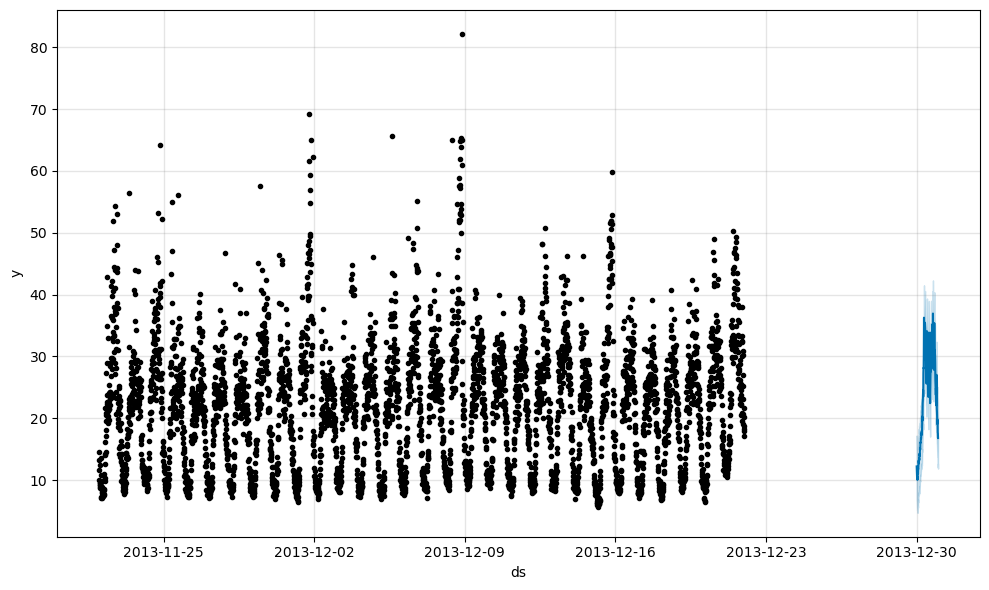

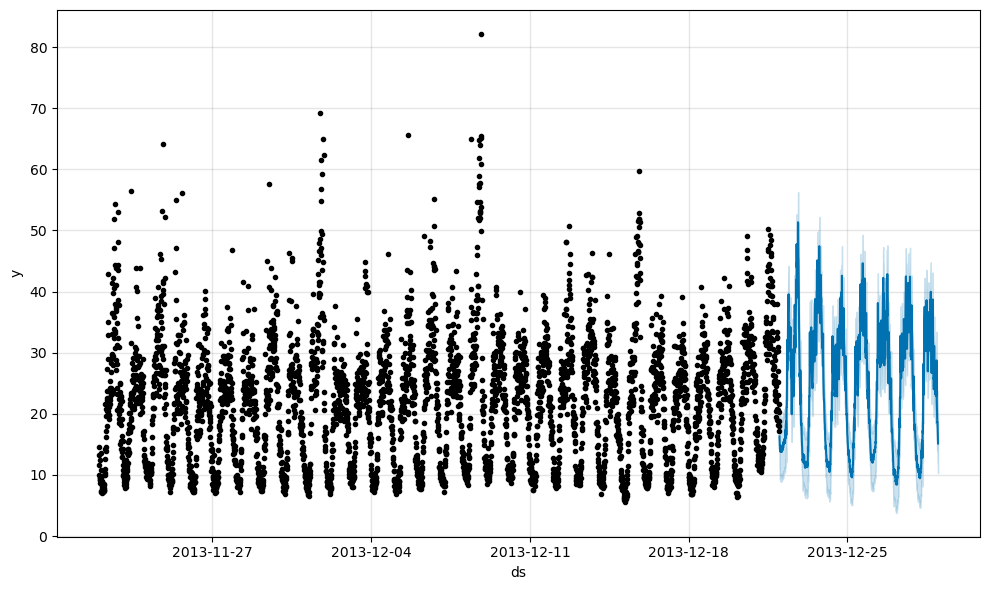

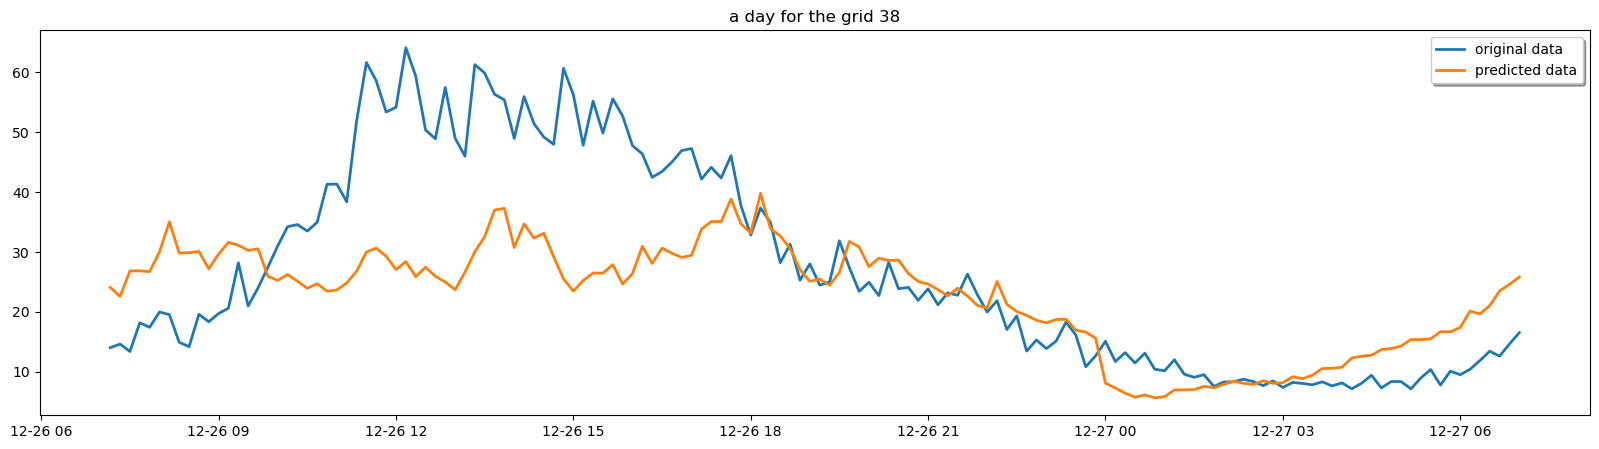

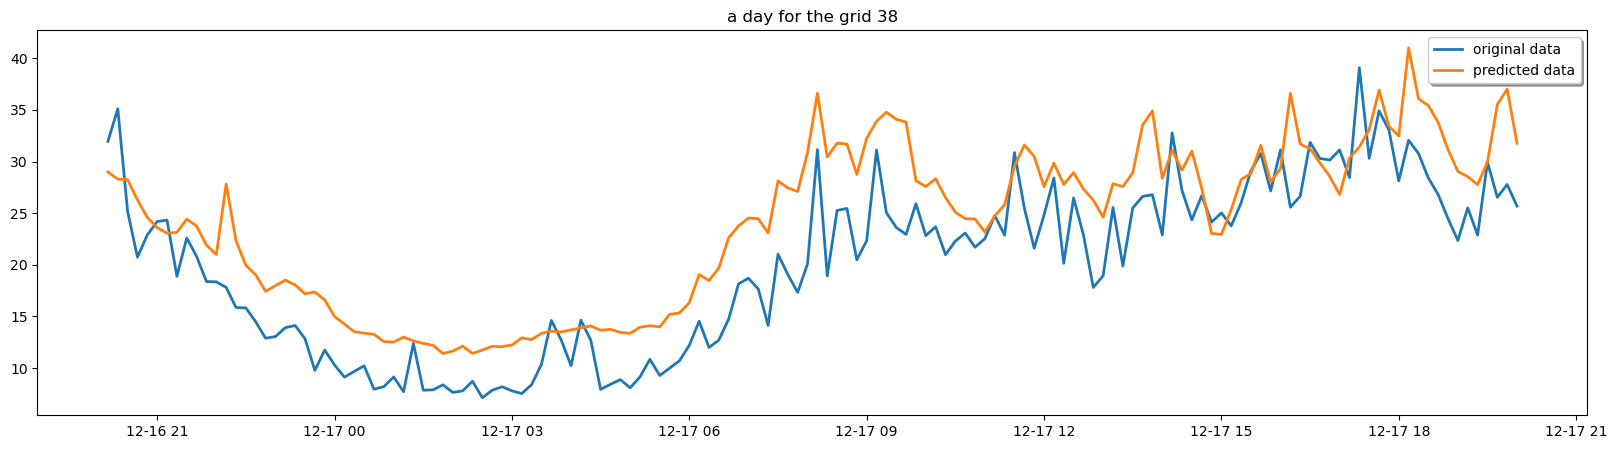

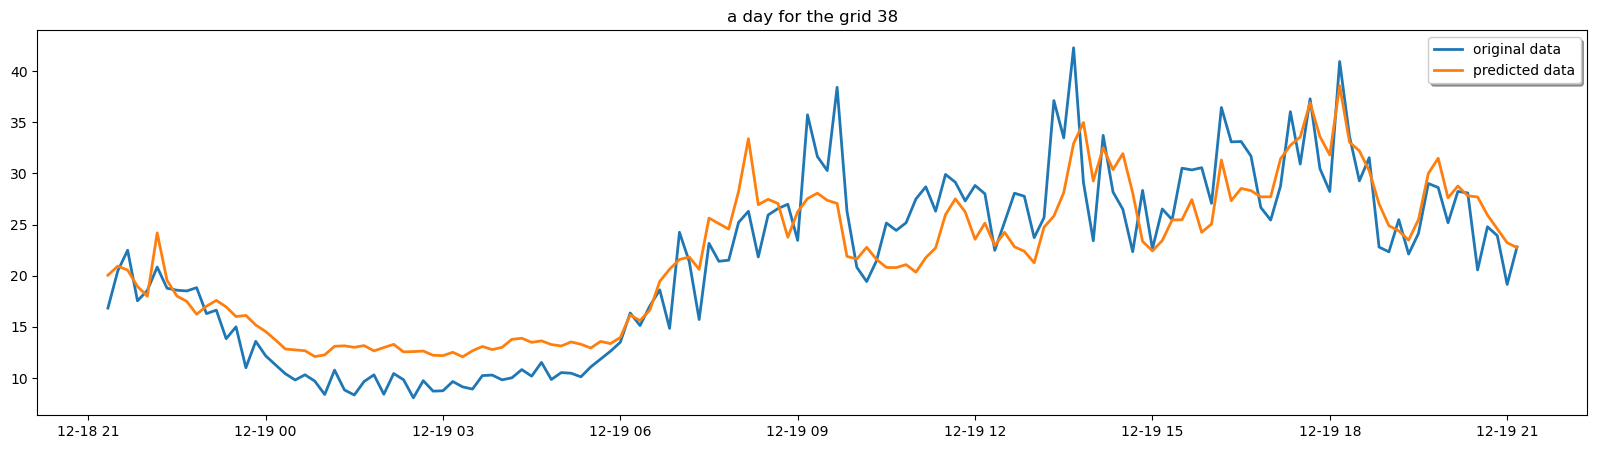

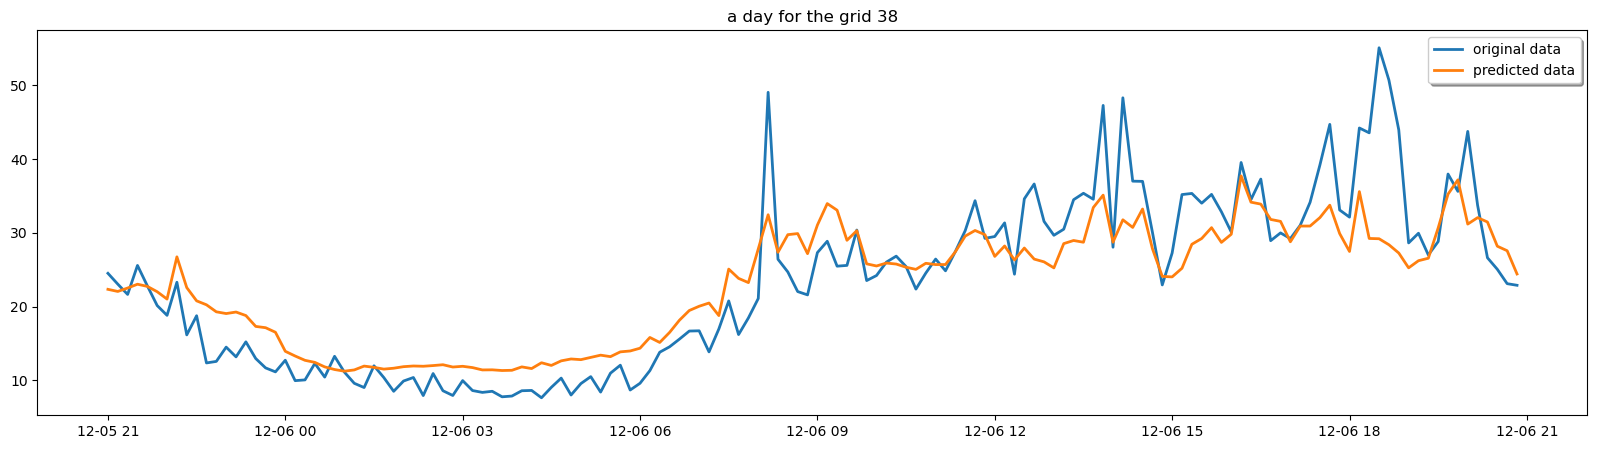

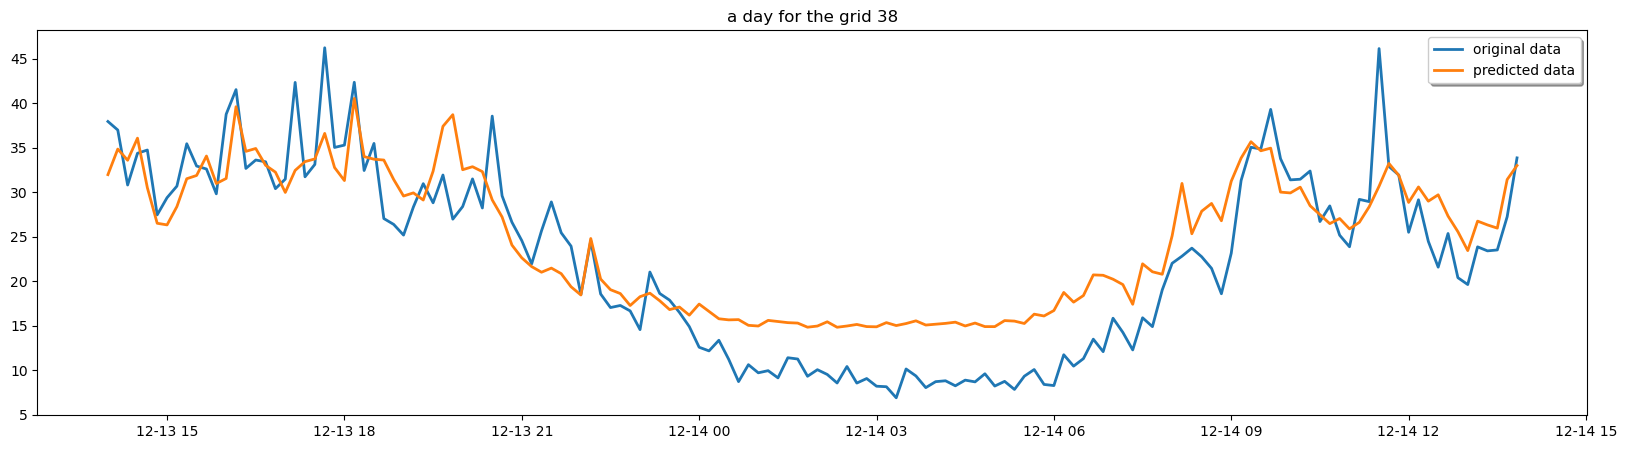

In [84]:
grid_days = day_predictions[-4320:].groupby("grid")[["y","yhat","error", "ds"]]
grids = list(grid_days.groups.keys())
get_random_grids = np.random.choice(grids, size = 5)

for grid in get_random_grids:
    grid_df = grid_days.get_group(grid)
    n_rows = grid_df.shape[0]
    random_day_start = np.random.randint(0, n_rows, size = 1)
# grid = grids[0]
    get_random_day = grid_df[random_day_start[0]:random_day_start[0]+144]
#plot the days and predictions
    fig, ax = plt.subplots(figsize = (20,5))
    ax.set_title('a day for the grid {}'.format(grid))
    line1, = ax.plot(get_random_day["ds"], get_random_day["y"], lw=2, label='original data')
    line2, = ax.plot(get_random_day["ds"], get_random_day["yhat"], lw=2, label='predicted data')
    leg = ax.legend(fancybox=True, shadow=True)
    plt.show()


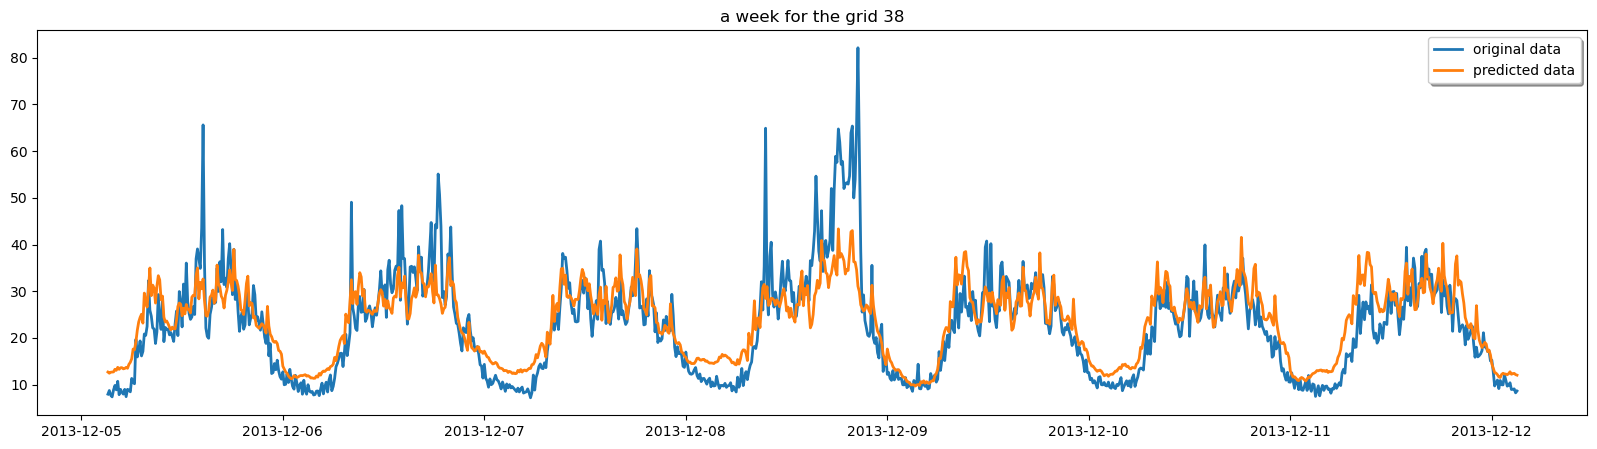

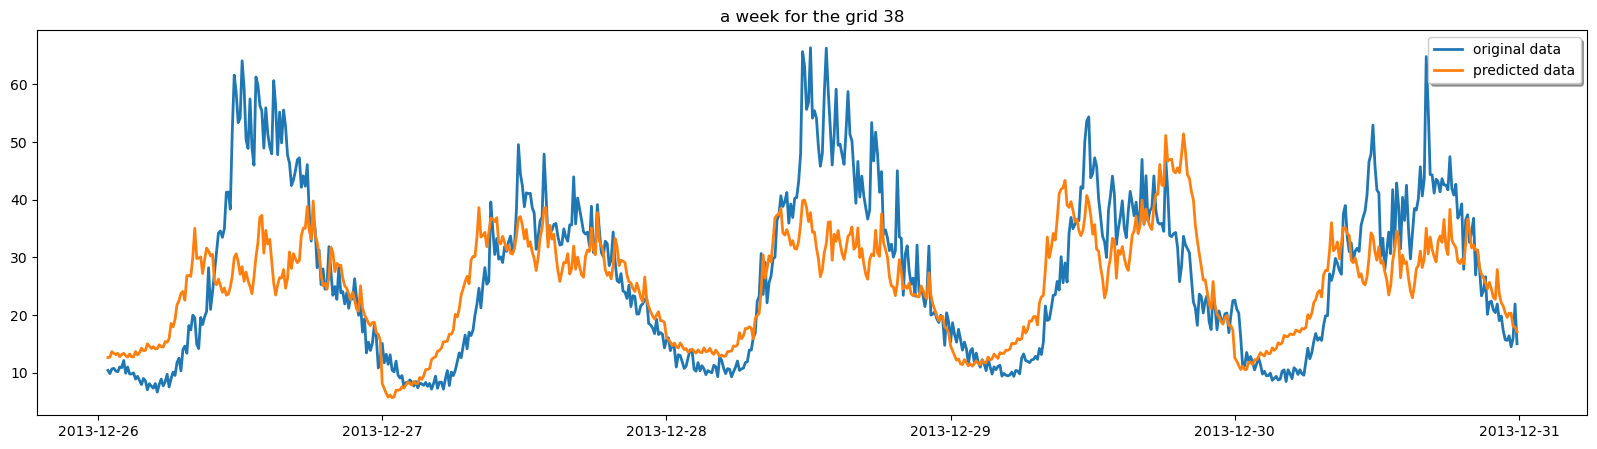

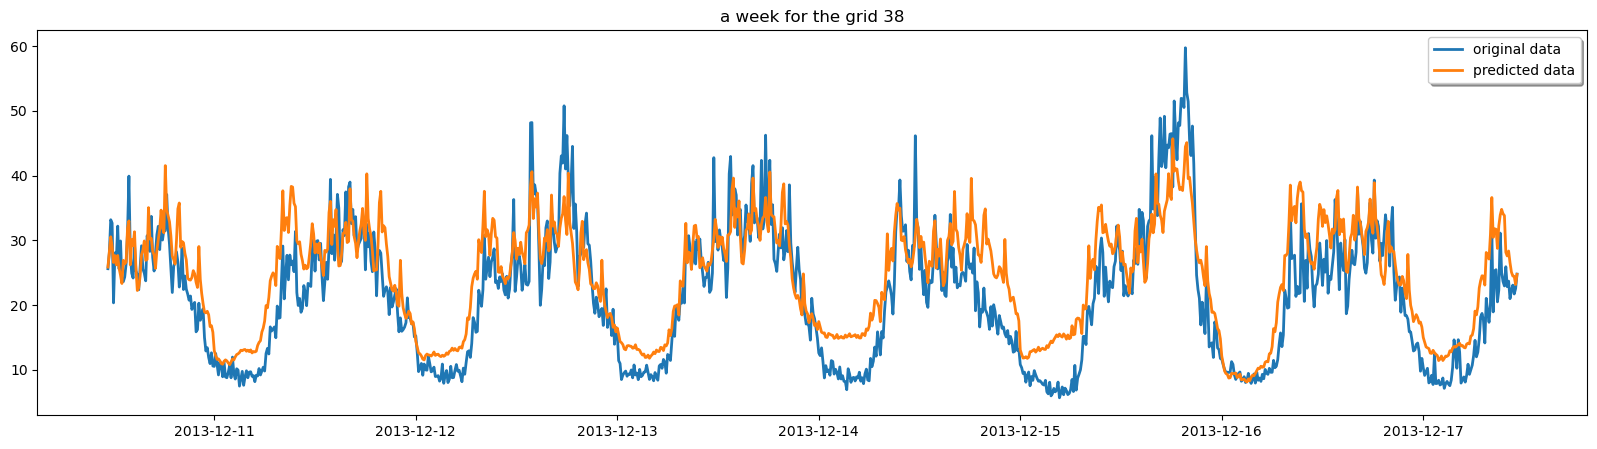

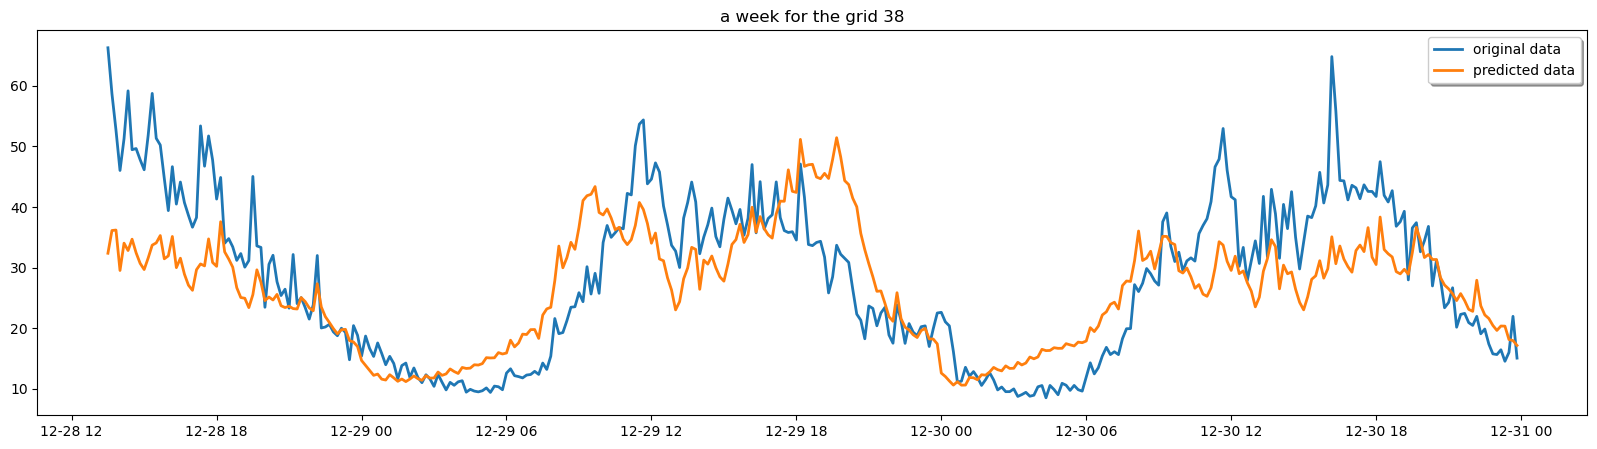

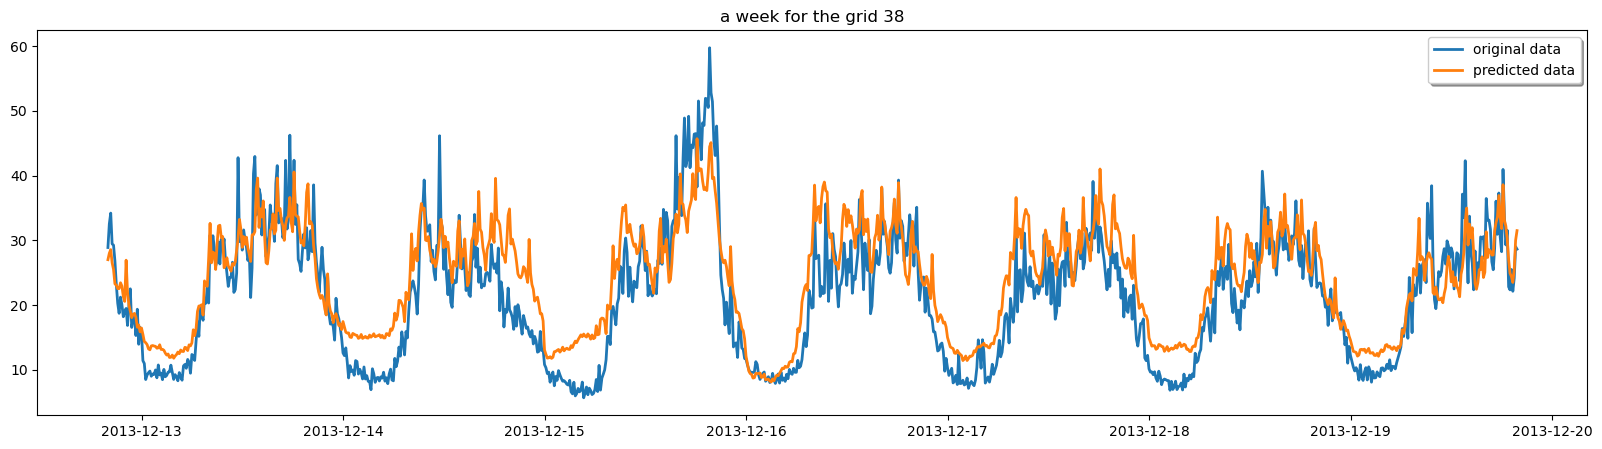

In [93]:
grid_weeks = week_predictions[-7*4*144:].groupby("grid")[["y","yhat","error", "ds"]]
grids = list(grid_days.groups.keys())
get_random_grids = np.random.choice(grids, size = 5)

for grid in get_random_grids:
    grid_df = grid_days.get_group(grid)
    n_rows = grid_df.shape[0]
    random_day_start = np.random.randint(0, n_rows, size = 1)
# grid = grids[0]
    get_random_day = grid_df[random_day_start[0]:random_day_start[0]+1008]
#plot the days and predictions
    fig, ax = plt.subplots(figsize = (20,5))
    ax.set_title('a week for the grid {}'.format(grid))
    line1, = ax.plot(get_random_day["ds"], get_random_day["y"], lw=2, label='original data')
    line2, = ax.plot(get_random_day["ds"], get_random_day["yhat"], lw=2, label='predicted data')
    leg = ax.legend(fancybox=True, shadow=True)
    plt.show()


In [87]:
nrmse(grid_df[-4320:])

0.2938130183558979

In [88]:
mape(grid_df[-4320:])

0.2607898429731505

In [97]:
nrmse(week_predictions[-4*7*144:])

0.29203144926710567

In [98]:
mape(week_predictions[-4*7*144:])

0.22549526300462738

In [75]:
week_predictions[-7*4*144:]

,y,yhat,error,ds,grid
0,14.522020,14.086758,0.435262,2013-12-01 00:00:00,38
1,16.606790,13.658892,2.947898,2013-12-01 00:10:00,38
2,14.151956,13.373628,0.778328,2013-12-01 00:20:00,38
3,13.085586,13.279335,-0.193748,2013-12-01 00:30:00,38
4,11.664906,13.011152,-1.346246,2013-12-01 00:40:00,38
...,...,...,...,...,...
1003,19.969331,18.659867,1.309465,2013-12-28 23:10:00,38
1004,19.277136,18.193304,1.083832,2013-12-28 23:20:00,38
1005,14.762119,16.718462,-1.956343,2013-12-28 23:30:00,38
1006,20.400707,16.023813,4.376893,2013-12-28 23:40:00,38


In [77]:
nrmse(week_predictions[-4*7*144:])

0.29302728883769547

In [78]:
mape(week_predictions[-4*7*144:])

0.2256327206752308

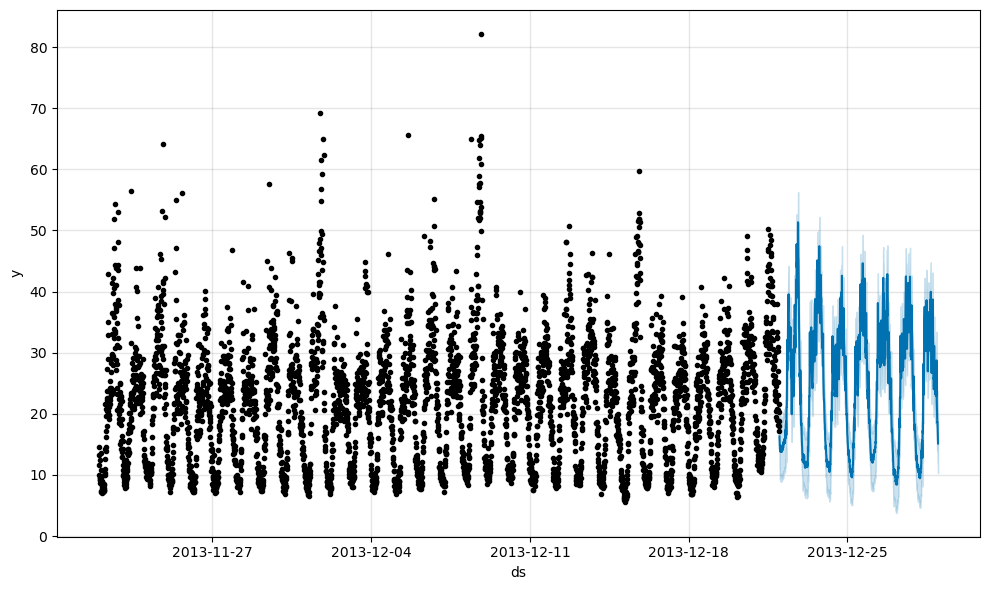

In [72]:
model.plot(forcast_week)